In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

%matplotlib inline

import os

In [2]:
DATA_ROOT = 'Data'
DB_NAME = 'amiunique-1month-aug17.sqlite3'

PATH_TO_DB = os.path.join(DATA_ROOT, DB_NAME)

In [3]:
con = sqlite3.connect(PATH_TO_DB)
df = pd.read_sql_query('select * from fpData', con)

In [4]:
drop_list = ['counter', 'id','time','pluginsJSHashed','canvasJSHashed',
             'webGLJsHashed','fontsFlashHashed']

df.drop(drop_list, axis = 1, inplace = True)

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn import cross_validation as cv
from sklearn.model_selection import train_test_split

/Users/joel/.virtualenvs/ds_generic/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
df.head()

,addressHttp,userAgentHttp,acceptHttp,hostHttp,connectionHttp,encodingHttp,languageHttp,orderHttp,pluginsJS,platformJS,...,webGLJs,fontsFlash,resolutionFlash,languageFlash,platformFlash,adBlock,vendorWebGLJS,rendererWebGLJS,octaneScore,sunspiderTime
0,55d1fdecf97155f039d7ebdf163d713744cce141,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:50.0) ...,Not specified,amiunique-backend,close,Not specified,Not specified,Connection Host User-Agent X-Real-IP,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS
1,d7620ba0d1c08ec6359fcd8275fa32efb0b4d17b,Mozilla/5.0 (Android 6.0.1; Mobile; rv:54.0) G...,"text/html,application/xhtml+xml,application/xm...",amiunique-backend,close,"gzip, deflate, br","de,de-DE;q=0.8,en-US;q=0.5,en;q=0.3",Upgrade-Insecure-Requests Referer Connection A...,,Linux armv7l,...,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",Flash not detected,Flash not detected,Flash not detected,Flash not detected,no,ARM,Mali-400 MP,,
2,f4d7978e4bf9a3180a96d6c7824c53cc13dd4d44,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,"text/html,application/xhtml+xml,application/xm...",amiunique-backend,close,"gzip, deflate, br","en-US,en;q=0.8,de;q=0.6,de-DE;q=0.4",Upgrade-Insecure-Requests Referer Connection A...,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS
3,ff3f9bf2797061dad81147e219e1bbda65e29df2,Mozilla/5.0 (Windows; U; Windows NT 5.2; en-US...,Not specified,amiunique-backend,close,Not specified,Not specified,Connection Host User-Agent X-Real-IP,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS
4,ae2faaf7e9e248db79a0e28f28b434b0db29e2af,Mozilla/5.0 (Windows; U; Windows NT 5.2; en-US...,Not specified,amiunique-backend,close,Not specified,Not specified,Connection Host User-Agent X-Real-IP,no JS,no JS,...,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS,no JS


In [7]:
#fingerprint_target = df.userAgentHttp
#fingerprint_data = df.drop('userAgentHttp', axis=1)

%time X = pd.get_dummies(df)

#fingerprint_data = fingerprint.drop('userAgentHttp', axis=1)
#fingerprint_target = fingerprint.userAgentHttp

CPU times: user 4.66 s, sys: 603 ms, total: 5.26 s
Wall time: 5.27 s


In [14]:
# Code From: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

X_samp = X.sample(n=100)

# generate the linkage matrix
Z = linkage(X_samp, 'ward')

In [9]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X_samp))
c

0.8722691950621142

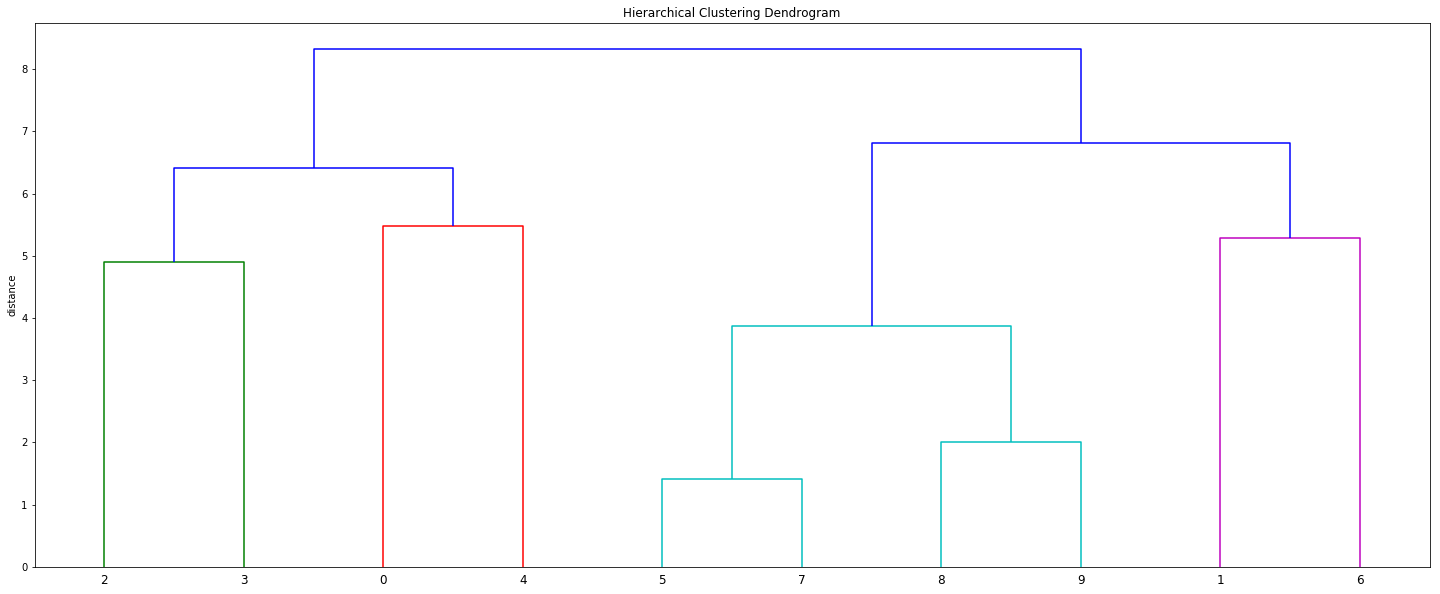

In [10]:

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
#plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
#    leaf_rotation=90.,  # rotates the x axis labels
#    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [11]:
# multicolumn label encoder (borrowed from Stockoverflow) to encode categorical values, added .astype(str)

from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        '''
        Note that .fit returned self: this is standard behavior for .fit methods in scikit-learn.
        '''
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

LE = MultiColumnLabelEncoder(columns = None)

In [28]:
# find a substring 'bot' in the userAgentHttp column (assuming that only good bots openly identify themselves as bots)
GoodBot = df['userAgentHttp'].str.contains("bot") # creates a column of Boolean True or False values
GoodBot = GoodBot.astype(int) # converts True/False to 1/0

In [41]:
from sklearn.cluster import MiniBatchKMeans

X = df #df.sample(n=100)

for cluster_size in range(2, 21):

    KMC = MiniBatchKMeans(n_clusters=cluster_size)

    pipeline = Pipeline([('LE', LE), ('KMC', KMC)])
    model = pipeline.fit(X)
    predicted = model.predict(X)
    
    tabs=pd.crosstab(predicted, GoodBot, margins=True)
    print(tabs)

userAgentHttp      0    1    All
row_0                           
0               9804   82   9886
1              16126   98  16224
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0               8099   70   8169
1              11406   53  11459
2               6425   57   6482
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0               9844   33   9877
1               5539   35   5574
2               5802   57   5859
3               4745   55   4800
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0               5135    8   5143
1               2359   56   2415
2              10340   35  10375
3               3892   72   3964
4               4204    9   4213
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0               8680   14   8694
1               4753   10   4763
2         

In [55]:
from sklearn.cluster import AgglomerativeClustering

X = df #df.sample(n=100)

for cluster_size in range(2, 21):

    AC = AgglomerativeClustering(n_clusters=cluster_size)

    pipeline = Pipeline([('LE', LE), ('AC', AC)])
    model = pipeline.fit_predict(X)
    #print(model.labels_)
    #predicted = model.predict(X)
    
    tabs=pd.crosstab(model, GoodBot, margins=True)
    print(tabs)

userAgentHttp      0    1    All
row_0                           
0              17390  111  17501
1               8540   69   8609
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0              11844   51  11895
1               8540   69   8609
2               5546   60   5606
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0               5546   60   5606
1               8540   69   8609
2               9086   15   9101
3               2758   36   2794
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0               8540   69   8609
1               2504   55   2559
2               9086   15   9101
3               2758   36   2794
4               3042    5   3047
All            25930  180  26110
userAgentHttp      0    1    All
row_0                           
0               6328   11   6339
1               2504   55   2559
2         